# 캘리포니아 주택 가격 예측

### 기본 정보

- 인구, 중간소득 등의 특성을 사용하여 주택 가격 예측
- 다중 회귀, 단방향 회귀(반대 : 다변량 회귀)
    - 다중 회귀 : 여러 개의 특성을 이용한 회귀
    - 단방향 회귀 : 하나의 데이터에 대한 예측
    - 다변량 회귀 : 여러 개의 수치를 예측하기 위한 회귀
- 회귀의 성능 측정 방법
    - 평균 제곱근의 오차를 활용
    - 평균 절대오차를 활용

- 일차적으로 파이썬 커널을 설정하면서 정상적으로 import가 되는지 체크해주었다. 
- 커널에 원하는 import 추가하는 법
    1. `venv`로 커널을 생성해준다. 
    2. `source .venv/bin/activate`로 venv를 활성화해준다. 
    3. 내부에서 `pip install`로 원하는 라이브러리를 다운로드 받는다. 

In [10]:
import sys

assert sys.version_info >= (3, 5)

import sklearn

assert sklearn.__version__ >= "0.20"

import numpy as np
import os

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

ROOT_DIR = '.'
CHAPTER_ID = 'end_to_end_project'
IMAGE_PATH = os.path.join(ROOT_DIR, 'images', CHAPTER_ID)
os.makedirs(IMAGE_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension = 'png', resolution = 100): 
    path = os.path.join(IMAGE_PATH, fig_id + '.' + fig_extension)
    print('그림 저장 : ', fig_id)

    if tight_layout:
        plt.tight_layout()
    
    plt.savefig(path, format=fig_extension, dpi=resolution)

import warnings

warnings.filterwarnings(action='ignore', message='^internal gelsd')


# 데이터 가져오기

In [5]:
import os
import tarfile
import urllib.request

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/rickiepark/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()


In [6]:

fetch_housing_data()

C:\Users\muhayuleejanghee\AppData\Local\Temp\ipykernel_20364\445020470.py:15: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  housing_tgz.extractall(path=housing_path)


In [11]:
import pandas as pd

csv_path = os.path.join(HOUSING_PATH, "housing.csv")

pd.read_csv(csv_path)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND


In [13]:
pd.read_csv(csv_path).head(10)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,NEAR BAY
6,-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,299200.0,NEAR BAY
7,-122.25,37.84,52.0,3104.0,687.0,1157.0,647.0,3.1200,241400.0,NEAR BAY
8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY
9,-122.25,37.84,52.0,3549.0,707.0,1551.0,714.0,3.6912,261100.0,NEAR BAY


- 해당 데이터는 대부분 수치로 되어있다. 
- longitude, latitude, housing_median_age, total_rooms, total_bedrooms, population, households, median_income, median_house_value, ocean_proximity가 존재하고, dictionary구조로 데이터를 뽑아내들 수 있다. 

In [21]:
housing = pd.read_csv(csv_path)

- pandas를 통해 읽어온 데이터셋은 `describe()`를 이용해 데이터 요약본을 알 수 있다. 하지만, 이는 숫자형 데이터만 조회가능

In [16]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


그림 저장 :  attribute_histogram_plots


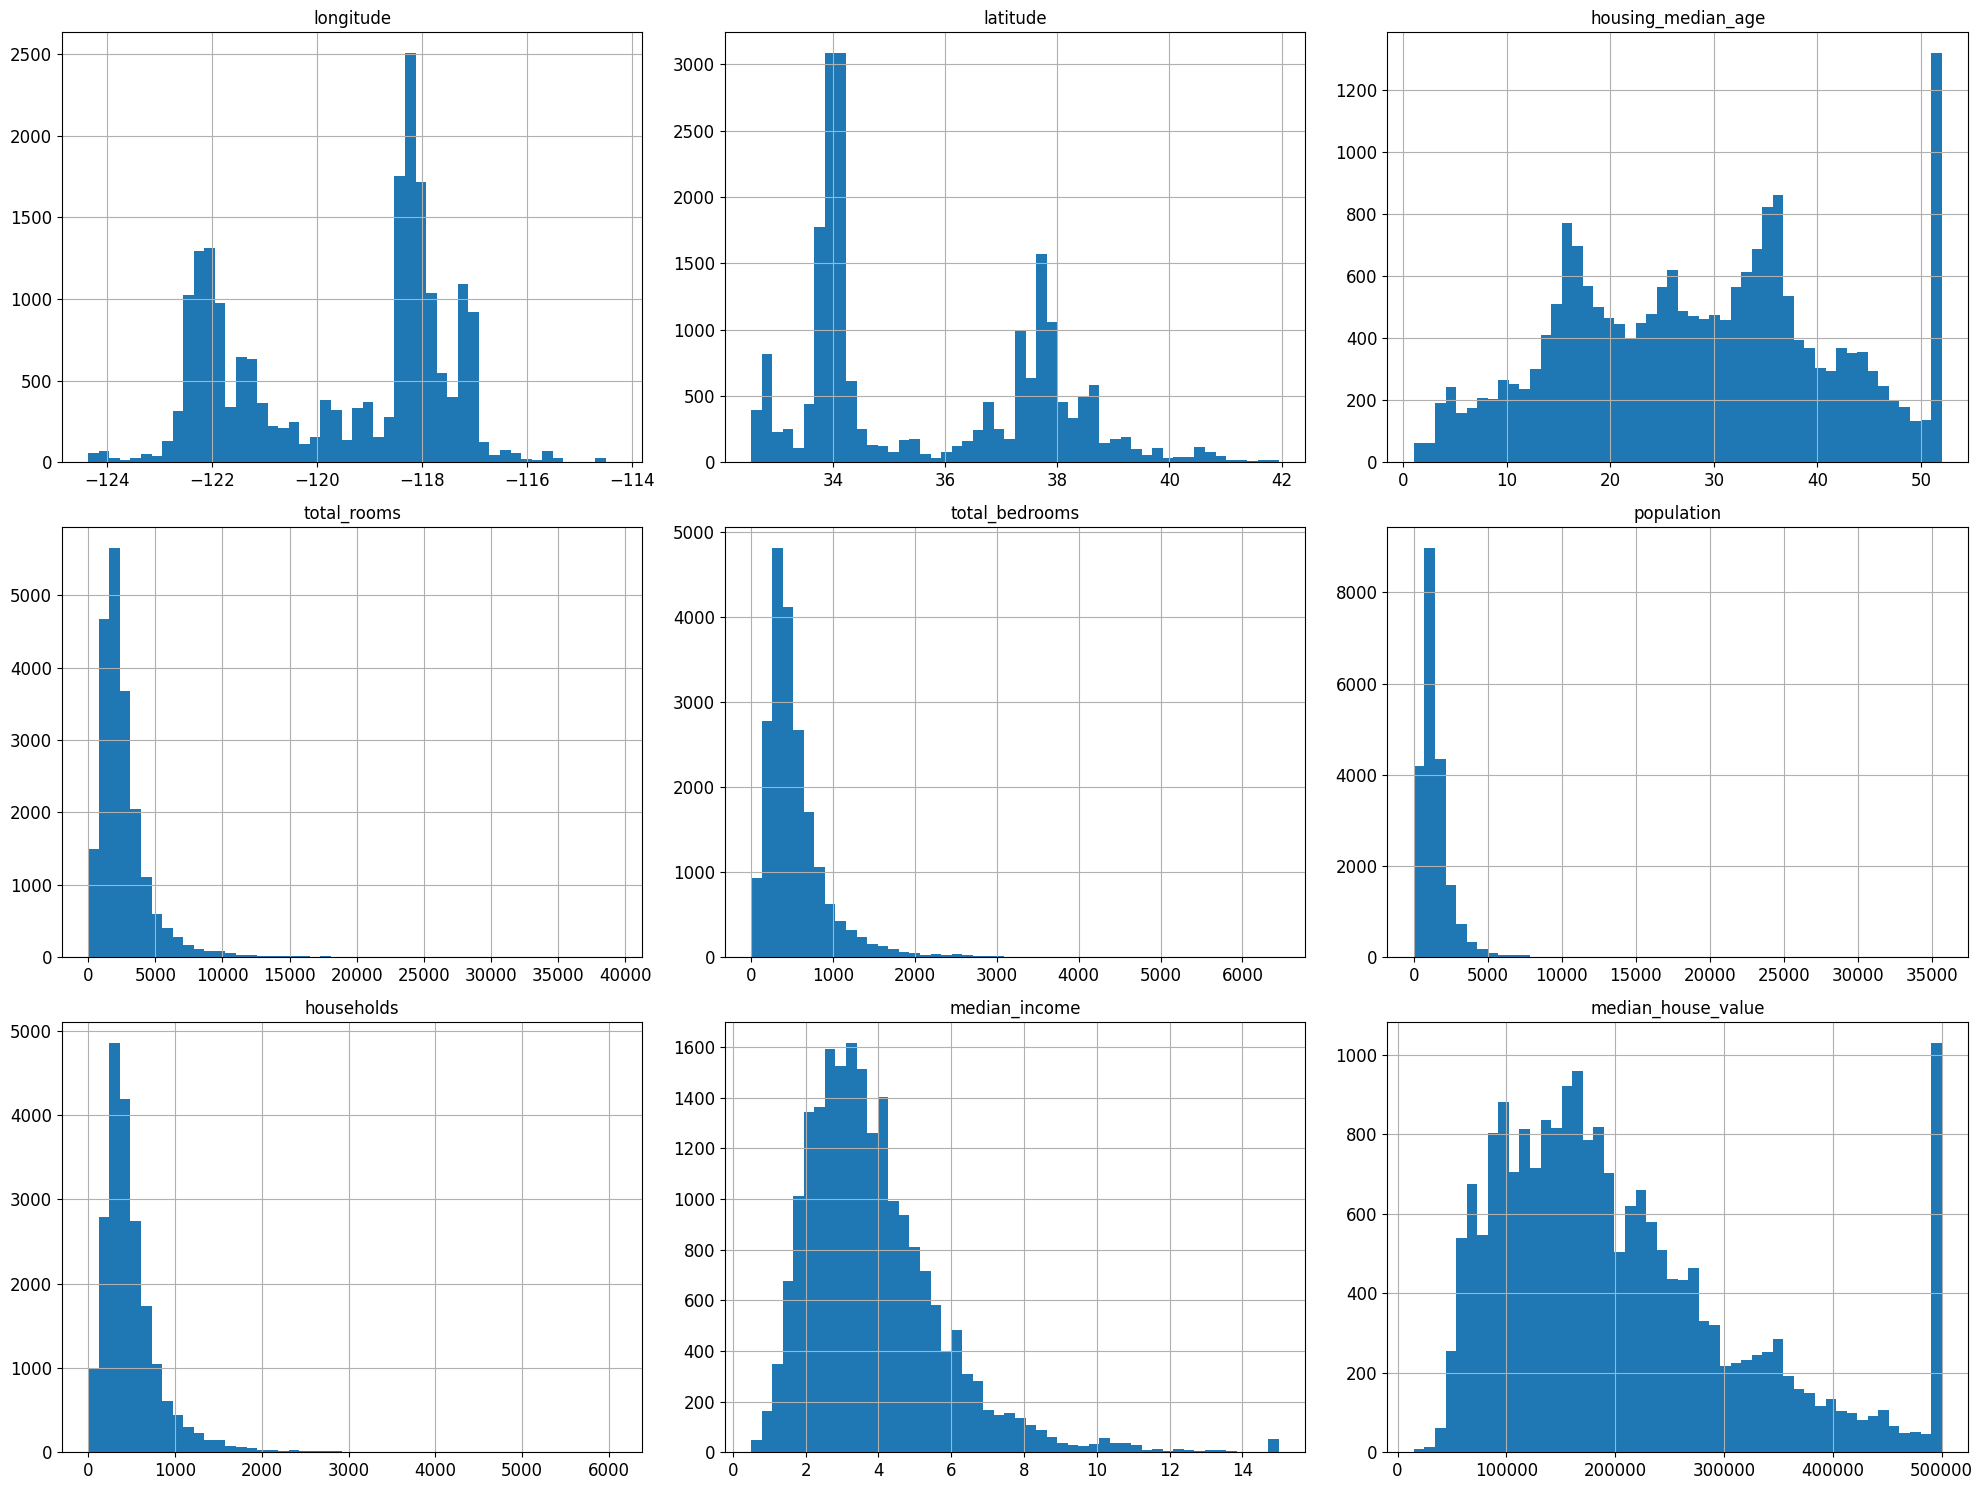

In [22]:
import matplotlib.pyplot as plt

housing.hist(bins=50, figsize=(20, 15))
save_fig('attribute_histogram_plots')

plt.show()

- 가우시안 분포가 되지 못하는 경우가 다양하다. 이런 데이터들을 전처리를 통해 정규분포화 시켜야 한다. 
- 각 분포별 x축이 다르다. 이를 일정하게 맞추는 작업이 추후 필요할 것 같다. 

# TestSet, TrainingSet 분리

- 테스트와 훈련 데이터가 중복될 경우, 과적합이 발생할 수 있다.
- 이를 방지하기 위해 훈련 데이터셋과 테스트 데이터셋을 사전에 분리한다. 

In [23]:
import numpy as np

# 실제로 scikit-learn에서 테스트 데이터를 분리해주는 함수가 존재한다 sklearn.train_test_split()
def split_train_set(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [24]:
train_set, test_set = split_train_set(housing, 0.2)

In [29]:
from zlib import crc32

def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_set_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_:test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

- 실제 개발 중 데이터셋에 변경이 있을 수 있다. 이 때 데이터를 다시 받을 수 있는 로직을 호출하면 된다. 

In [30]:
housing_with_id = housing.reset_index()
train_set, test_set = split_train_set_by_id(housing_with_id, 0.2, "index")

In [31]:
import sklearn.model_selection


train_set, test_set = sklearn.model_selection.train_test_split(housing, test_size=0.2, random_state=42)

- 결국 sklearn쓰는게 제일 편하다

In [33]:
test_set.head() # 인덱스가 다 섞임

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
20046,-119.01,36.06,25.0,1505.0,NaN,1392.0,359.0,1.6812,47700.0,INLAND
3024,-119.46,35.14,30.0,2943.0,NaN,1565.0,584.0,2.5313,45800.0,INLAND
15663,-122.44,37.80,52.0,3830.0,NaN,1310.0,963.0,3.4801,500001.0,NEAR BAY
20484,-118.72,34.28,17.0,3051.0,NaN,1705.0,495.0,5.7376,218600.0,<1H OCEAN
9814,-121.93,36.62,34.0,2351.0,NaN,1063.0,428.0,3.7250,278000.0,NEAR OCEAN


# 예제 - median_income

- median_income은 연속적인 값이다. 
- 이를 categorized factor로 만들어주어야 한다. 
- 특정 범주를 정해 라벨링을 해주는 방식으로 카테고리화 시킨다. 

In [35]:
housing['income_cat'] = pd.cut(
    housing['median_income'],
    bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
    labels=[1, 2, 3, 4, 5]
)

In [38]:
housing['income_cat'].value_counts()

income_cat
3    7236
2    6581
4    3639
5    2362
1     822
Name: count, dtype: int64

<Axes: >

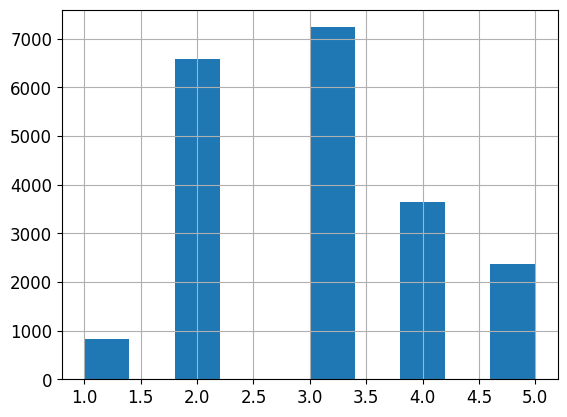

In [39]:
housing['income_cat'].hist()

In [40]:
import sklearn.model_selection as model_selection

split = model_selection.StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(housing, housing['income_cat']):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [44]:
strat_test_set['income_cat'].value_counts() / len(strat_test_set)

income_cat
3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: count, dtype: float64

In [45]:
housing['income_cat'].value_counts() / len(housing)

income_cat
3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: count, dtype: float64

- 사실 stratify로 train_test_split해주는 로직은 sklearn.model_selection에 이미 존재한다.

In [46]:
st_train_set, st_test_set = model_selection.train_test_split(housing, test_size=0.2, random_state=42, stratify=housing['income_cat'])

In [47]:
st_train_set['income_cat'].value_counts() / len(st_train_set)

income_cat
3    0.350594
2    0.318859
4    0.176296
5    0.114462
1    0.039789
Name: count, dtype: float64

In [48]:
for set_ in (strat_test_set, strat_train_set):
    set_.drop('income_cat', axis=1, inplace=True)

# 데이터이해를 위한 탐색과 시각화

In [49]:
housing_traing = strat_train_set.copy()

<Axes: xlabel='longitude', ylabel='latitude'>

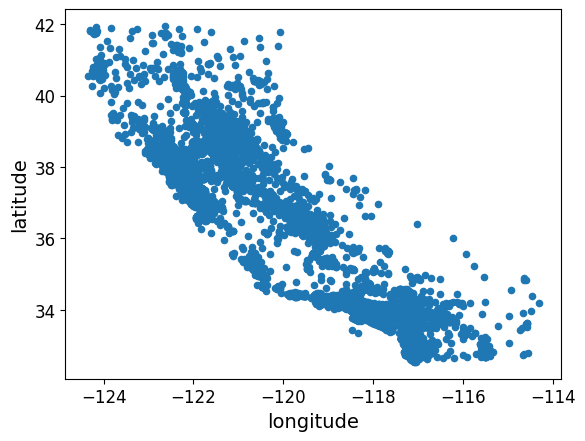

In [50]:
housing_traing.plot(kind='scatter', x='longitude', y='latitude')

<Axes: xlabel='longitude', ylabel='latitude'>

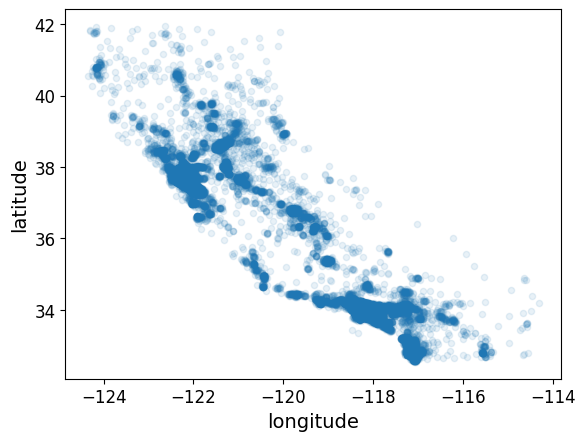

In [51]:
housing_traing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.1)


- scatter plot으로 전체의 분포를 점으로 찍을 수 있다. 
- 그런데 alpha로 조금 더 진한 부분이 선택적으로 보이게 된다. 
- `alpha`를 이용해 투명도를 설정할 수 있다. 이를 통해 빈도가 높은 곳은 진하게 확인할 수 있다. 

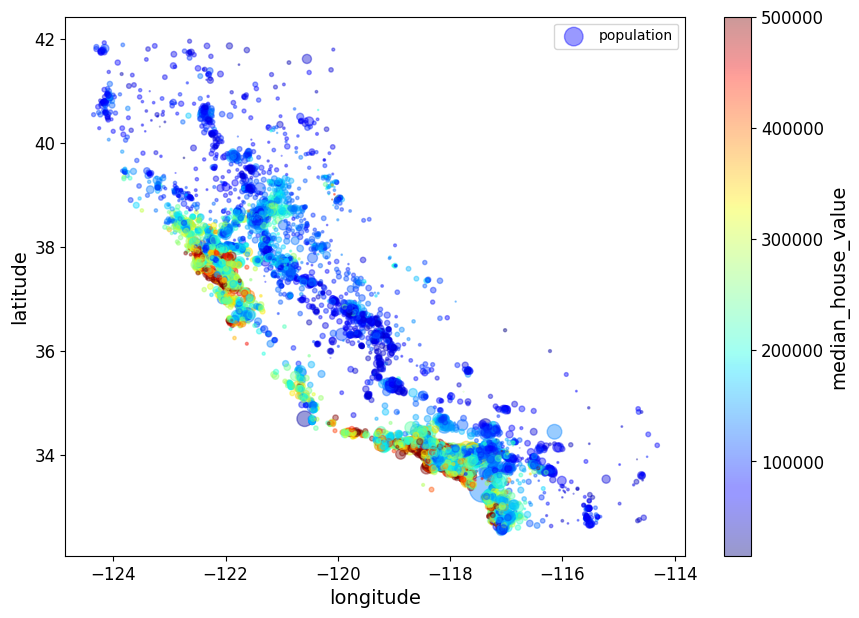

In [55]:
housing_traing.plot(
    kind='scatter', 
    x='longitude', 
    y='latitude', 
    alpha=0.4, 
    s=housing_traing['population']/100, 
    label='population', 
    figsize=(10, 7), 
    c='median_house_value',
    cmap=plt.get_cmap('jet'), 
    colorbar=True, 
    sharex=False)
plt.legend()


- 현재의 구조는 위도, 경도를 통해 생성되어있는 구조이다. 
- 이를 지도 위에 표기해보자. 

In [56]:
image_path = os.path.join(ROOT_DIR, 'images', 'end_to_end_project')
os.makedirs(image_path, exist_ok=True)
filename = 'california.png'
url = DOWNLOAD_ROOT + 'images/end_to_end_project/' + filename
urllib.request.urlretrieve(url, os.path.join(image_path, filename))

('.\\images\\end_to_end_project\\california.png',
 <http.client.HTTPMessage at 0x18dbe6a16e0>)

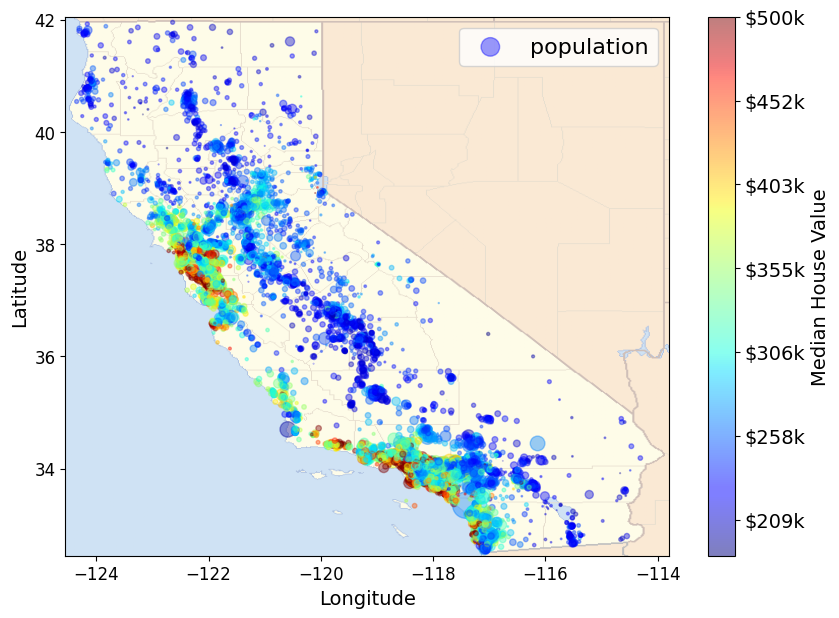

In [57]:
import matplotlib.image as mpimg

california_img = mpimg.imread(os.path.join(image_path, filename))
ax = housing_traing.plot(
    kind='scatter', 
    x='longitude', 
    y='latitude', 
    alpha=0.4, 
    s=housing_traing['population']/100, 
    label='population', 
    figsize=(10, 7), 
    c='median_house_value',
    cmap=plt.get_cmap('jet'), 
    colorbar=False)

plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5, cmap=plt.get_cmap('jet'))

plt.ylabel('Latitude', fontsize = 14)
plt.xlabel('Longitude', fontsize = 14)

prices = housing_traing['median_house_value']
tick_values = np.linspace(prices.min(), prices.max(), 11)
cbar = plt.colorbar(ticks=tick_values/prices.max())
cbar.ax.set_yticklabels(['$%dk'%(round(v/1000)) for v in tick_values], fontsize=14)
cbar.set_label('Median House Value', fontsize=14)

plt.legend(fontsize=16)
plt.show()


- 지금까지는 데이터를 시각화해 인사이트를 얻기 위한 과정이었다. 
- 이번엔 각 데이터간의 상관관계를 찾아야 한다.
- 이를 위해 상관관계 행렬을 얻기 위한 함수인 `corr()`이 존재한다. 

In [66]:
corr_matrix = housing_traing.corr()

ValueError: could not convert string to float: 'INLAND'